<a href="https://colab.research.google.com/github/pdrzxzz/who-suicide-analysis/blob/main/who_suicides_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [555]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib.ticker as mticker
import kagglehub

# Plot style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)
pd.options.display.float_format = '{:,.2f}'.format


# FETCH DATA

In [556]:
path = kagglehub.dataset_download("szamil/who-suicide-statistics")

print("Path to dataset files:", path)

df = pd.read_csv(os.path.join(path, 'who_suicide_statistics.csv'))

Path to dataset files: /kaggle/input/who-suicide-statistics


# GLANCE OF DATA

In [557]:
df.head()

,country,year,sex,age,suicides_no,population
0,Albania,1985,female,15-24 years,NaN,"277,900.00"
1,Albania,1985,female,25-34 years,NaN,"246,800.00"
2,Albania,1985,female,35-54 years,NaN,"267,500.00"
3,Albania,1985,female,5-14 years,NaN,"298,300.00"
4,Albania,1985,female,55-74 years,NaN,"138,700.00"


In [558]:
df['year'].value_counts().sort_values(ascending=True).head()

,count
year,
2016,300
1979,672
1980,804
1984,840
1982,936


In [559]:
df = df[df['year'] != 2016]

2016 has few data.

In [560]:
print(f"Number of countries: {len(df['country'].unique())}")
print(f"Data from {df['year'].min()} to {df['year'].max()}")
YEAR_RANGE = f"{df['year'].min()} to {df['year'].max()}"

Number of countries: 141
Data from 1979 to 2015


In [561]:
age_values = df['age'].unique()
age_values = np.insert(age_values, 0, age_values[3])
age_values = np.delete(age_values, 4)
df['age'] = pd.Categorical(df['age'], categories=age_values, ordered=True)
df['sex'] = pd.Categorical(df['sex'])
for x in age_values:
  print(x)

5-14 years
15-24 years
25-34 years
35-54 years
55-74 years
75+ years


/tmp/ipython-input-561-2997097332.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'] = pd.Categorical(df['age'], categories=age_values, ordered=True)
/tmp/ipython-input-561-2997097332.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sex'] = pd.Categorical(df['sex'])


In [562]:
df = df[~df['country'].isin(['Cayman Islands', 'Saint Kitts and Nevis', 'Egypt'])]

Cayman Islands and Saint kitts and Nevis suicides_no = 0, because they have
small population.

Egypt population seems to be miscalculated.

In [563]:
df.loc[:, 'suicides_no/100kpop'] = (df.loc[:, 'suicides_no'] * 100000) / df.loc[:, 'population']

In [564]:
print(f"The dataset contains {df.shape[0]:,} rows and {df.shape[1]} columns.")

The dataset contains 42,504 rows and 7 columns.


In [565]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42504 entries, 0 to 43775
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   country              42504 non-null  object  
 1   year                 42504 non-null  int64   
 2   sex                  42504 non-null  category
 3   age                  42504 non-null  category
 4   suicides_no          40356 non-null  float64 
 5   population           37728 non-null  float64 
 6   suicides_no/100kpop  35580 non-null  float64 
dtypes: category(2), float64(3), int64(1), object(1)
memory usage: 2.0+ MB


In [566]:
df.describe()

,year,suicides_no,population,suicides_no/100kpop
count,"42,504.00","40,356.00","37,728.00","35,580.00"
mean,"1,998.36",198.45,"1,641,901.01",13.29
std,10.29,811.38,"3,623,217.75",19.96
min,"1,979.00",0.00,259.00,0.00
25%,"1,990.00",1.00,"85,378.50",0.85
50%,"1,999.00",15.00,"378,564.00",6.08
75%,"2,007.00",95.00,"1,285,298.50",17.16
max,"2,015.00","22,338.00","43,805,214.00",300.75


# DATA CLEANING

## Null values

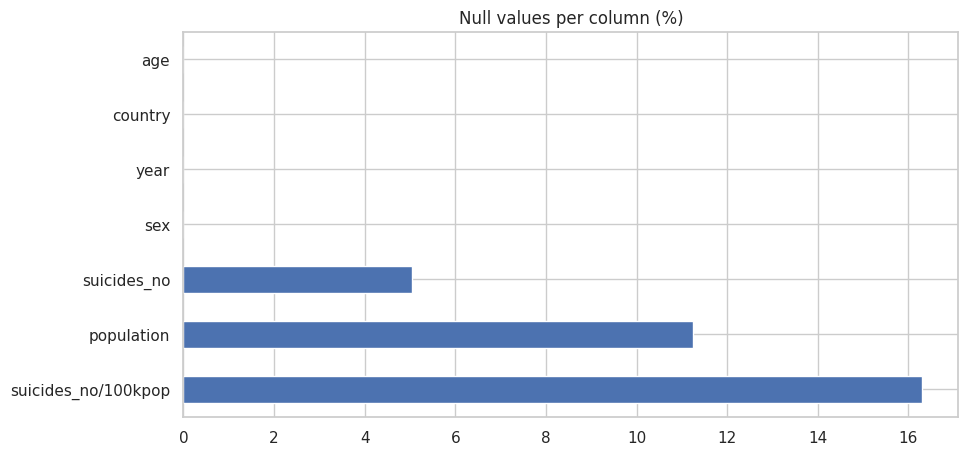

In [567]:
(df.isnull().sum()/len(df)*100).sort_values(ascending=False).plot.barh()
plt.title('Null values per column (%)')
plt.show()

In [568]:
df = df.dropna()

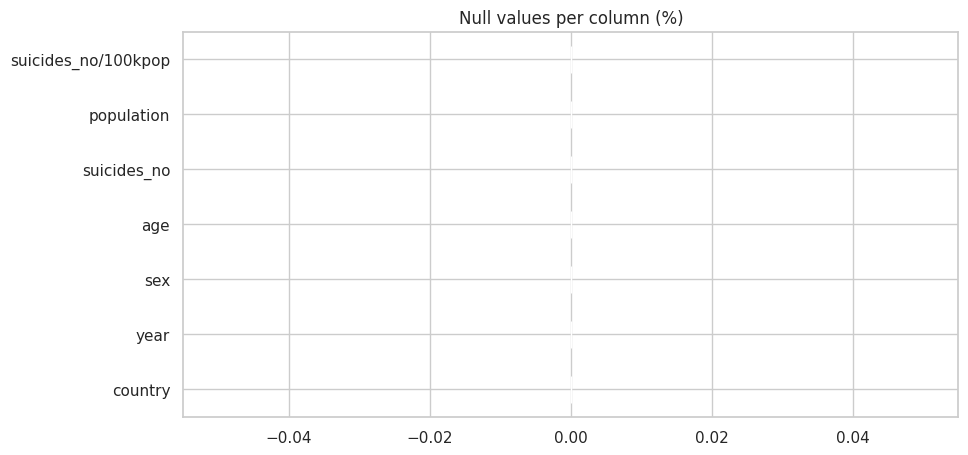

In [569]:
(df.isnull().sum()/len(df)*100).sort_values(ascending=False).plot.barh()
plt.title('Null values per column (%)')
plt.show()

In [570]:
df['suicides_no'] = df.loc[:, 'suicides_no'].astype(int)
df['population'] = df.loc[:, 'population'].astype(int)

In [571]:
print(f"The dataset now contains {df.shape[0]:,} rows (7716 rows dropped)")

The dataset now contains 35,580 rows (7716 rows dropped)


Any duplicated rows?

In [572]:
df.duplicated().sum()

np.int64(0)

In [573]:
df.dtypes

,0
country,object
year,int64
sex,category
age,category
suicides_no,int64
population,int64
suicides_no/100kpop,float64


In [574]:
df['sex'].value_counts(normalize=True)

,proportion
sex,
female,0.50
male,0.50


# Ploting

In [576]:
COLOR1='#eb6077'
COLOR2='#493443'

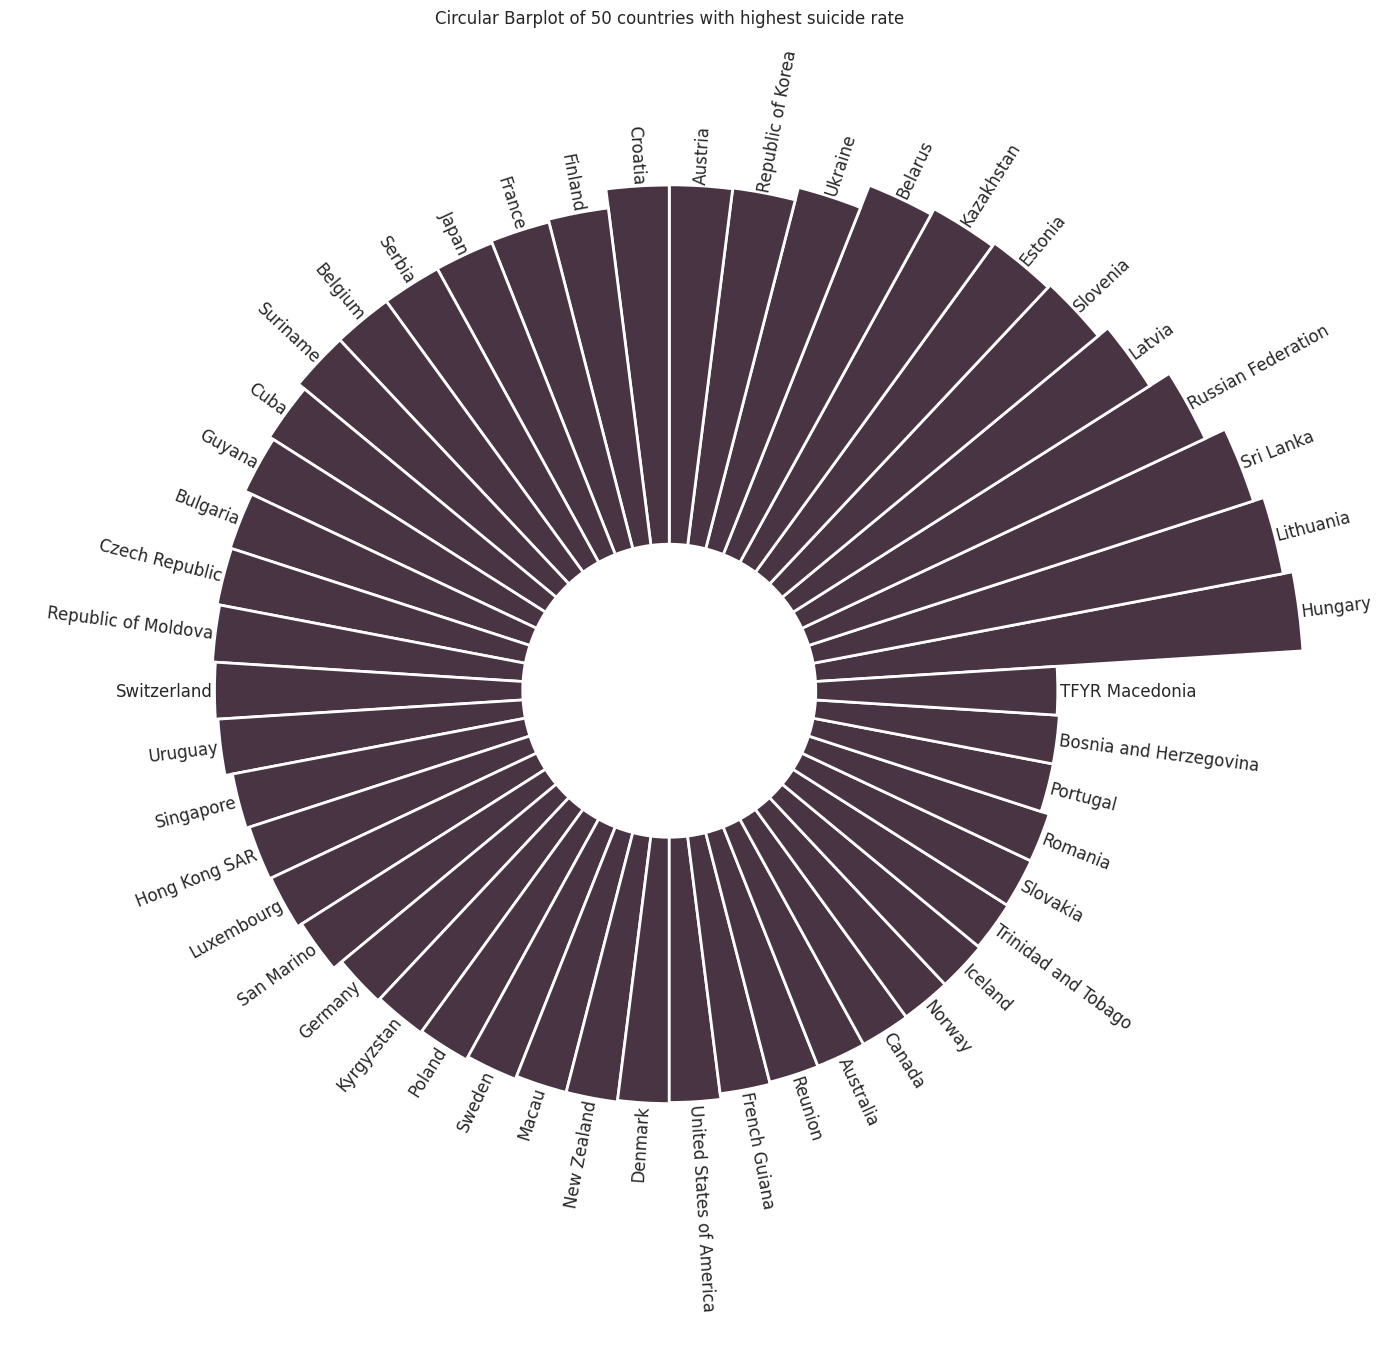

In [625]:
df_grouped = df.groupby('country')['suicides_no/100kpop'].mean().nlargest(50).reset_index()

# set figure size
plt.figure(figsize=(14, 14))

# plot polar axis
ax = plt.subplot(111, polar=True)

# remove grid
plt.axis('off')

# Set the coordinates limits
upperLimit = 1000
lowerLimit = 300

max = df_grouped['suicides_no/100kpop'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (upperLimit - lowerLimit) / max
heights = slope * df_grouped['suicides_no/100kpop'] + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(df_grouped.index)

indexes = list(range(1, len(df_grouped.index)+1))
angles = [element * width for element in indexes]

bars = ax.bar(
    x=angles,
    height=heights,
    width=width,
    bottom=lowerLimit,
    linewidth=2,
    edgecolor="white",
    color=COLOR2)

# little space between the bar and the label
labelPadding = 4

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df_grouped["country"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else:
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle,
        y=lowerLimit + bar.get_height() + labelPadding,
        s=label,
        ha=alignment,
        va='center',
        rotation=rotation,
        rotation_mode="anchor")

plt.title('Circular Barplot of 50 countries with highest suicide rate')
plt.tight_layout()
plt.show()

Plot Analysis:  
An overview of the countries with the highest suicide rates.

In [678]:
def plot_suicide_charts(df, groupby_cols, chart_type='line', top_n=None, lowest=False,
                        title_suffix="", color_abs=None, color_rate=None,
                        fig_size=(10, 5), abs_y_lim=None, rate_y_lim=None,
                        abs_x_lim=None, rate_x_lim=None,
                        x_ticks_rotation=45, y_ticks_rotation=45,
                        horizontal=False, space_legend=True):
    """
    Plot absolute and rate suicide charts based on grouping columns.

    Parameters:
    - df: original DataFrame
    - groupby_cols: string or list of columns to group by
    - chart_type: 'line' or 'bar'
    - top_n: for top-N countries, use int and sort values
    - lowest: if True, shows the lowest N instead of highest
    - title_suffix: text to add at the end of the chart title
    - color_abs: color for absolute chart
    - color_rate: color for rate chart
    - fig_size: tuple for figure size
    - abs_y_lim: y-axis limit for absolute chart
    - rate_y_lim: y-axis limit for rate chart
    - x_ticks_rotation: rotation angle for x-axis labels
    - horizontal: if True, plots bar charts in horizontal orientation
    """
    if isinstance(groupby_cols, str):
        groupby_cols = [groupby_cols]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)

    # Absolute suicides
    df_abs = df.groupby(groupby_cols, observed=True)['suicides_no'].sum().reset_index()
    if top_n:
        df_abs = df_abs.sort_values('suicides_no', ascending=lowest).head(top_n)

    # Rate suicides
    df_rate = df.groupby(groupby_cols, observed=True)['suicides_no/100kpop'].mean().reset_index()
    if top_n:
        df_rate = df_rate.sort_values('suicides_no/100kpop', ascending=lowest).head(top_n)

    # Determine hue and palette
    use_hue = len(groupby_cols) > 1
    hue_col = groupby_cols[1] if use_hue else None
    palette_abs = color_abs if use_hue else None
    palette_rate = color_rate if use_hue else None
    color_abs = None if use_hue else color_abs
    color_rate = None if use_hue else color_rate

    # Plotting
    if chart_type == 'line':
        sns.lineplot(
            data=df_abs, x=groupby_cols[0], y='suicides_no',
            hue=hue_col, ax=ax1,
            color=color_abs, palette=palette_abs
        )
        sns.lineplot(
            data=df_rate, x=groupby_cols[0], y='suicides_no/100kpop',
            hue=hue_col, ax=ax2,
            color=color_rate, palette=palette_rate
        )

    else:
        if horizontal:
            sns.barplot(
                data=df_abs, y=groupby_cols[0], x='suicides_no',
                hue=hue_col, ax=ax1,
                color=color_abs, palette=palette_abs
            )
            sns.barplot(
                data=df_rate, y=groupby_cols[0], x='suicides_no/100kpop',
                hue=hue_col, ax=ax2,
                color=color_rate, palette=palette_rate
            )
        else:
            sns.barplot(
                data=df_abs, x=groupby_cols[0], y='suicides_no',
                hue=hue_col, ax=ax1,
                color=color_abs, palette=palette_abs
            )
            sns.barplot(
                data=df_rate, x=groupby_cols[0], y='suicides_no/100kpop',
                hue=hue_col, ax=ax2,
                color=color_rate, palette=palette_rate
            )

    # Absolute chart config
    ax1.set_title(f"Absolute Suicides {title_suffix}")
    ax1.set_xlabel("" if not horizontal else "Suicides")
    ax1.set_ylabel("" if horizontal else "Suicides")
    if abs_y_lim:
        ax1.set_ylim(abs_y_lim)
    if abs_x_lim:
        ax1.set_xlim(abs_x_lim)
    ax1.tick_params(axis='x' if not horizontal else 'y', rotation=x_ticks_rotation if not horizontal else y_ticks_rotation)

    # Rate chart config
    ax2.set_title(f"Suicide Rate {title_suffix}")
    ax2.set_xlabel("" if not horizontal else "Rate (1/100kpop)")
    ax2.set_ylabel("" if horizontal else "Rate (1/100kpop)")
    if rate_y_lim:
        ax2.set_ylim(rate_y_lim)
    if rate_x_lim:
        ax2.set_xlim(rate_x_lim)
    ax2.tick_params(axis='x' if not horizontal else 'y', rotation=x_ticks_rotation if not horizontal else y_ticks_rotation)

    if space_legend:
      if(color_abs != color_rate):
        print('To use space_legend, color_abs must be equal to color_rate')
        return
      legend = ax1.get_legend()
      if legend is not None:
          legend.remove()

      plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.3)
    plt.tight_layout()
    plt.show()


## Year

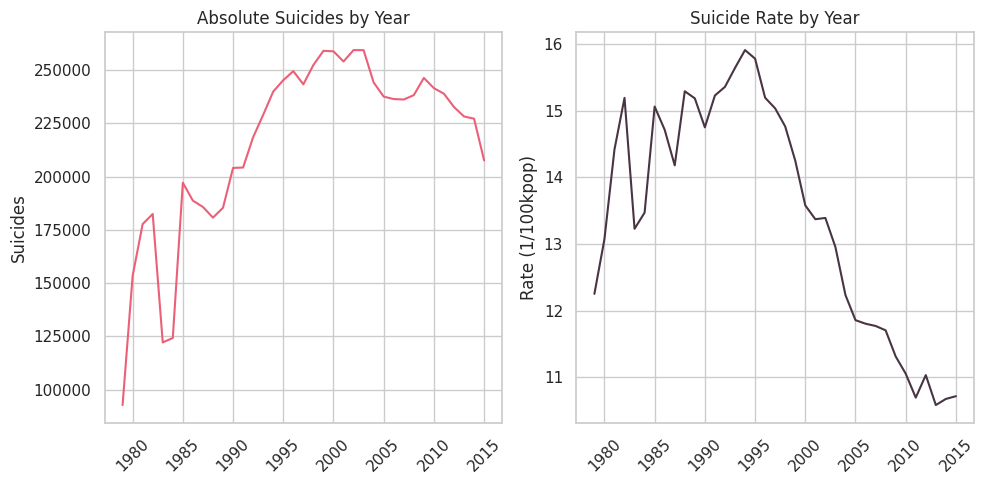

In [577]:
# Suicides by year (line chart)
plot_suicide_charts(
    df,
    groupby_cols='year',
    chart_type='line',
    title_suffix="by Year",
    color_abs=COLOR1,
    color_rate=COLOR2,
)

Plot Analysis:   
The global number of suicides dropped abruptly from 1982 to 1983.  
The global suicide rate began to decline significantly around 1995.

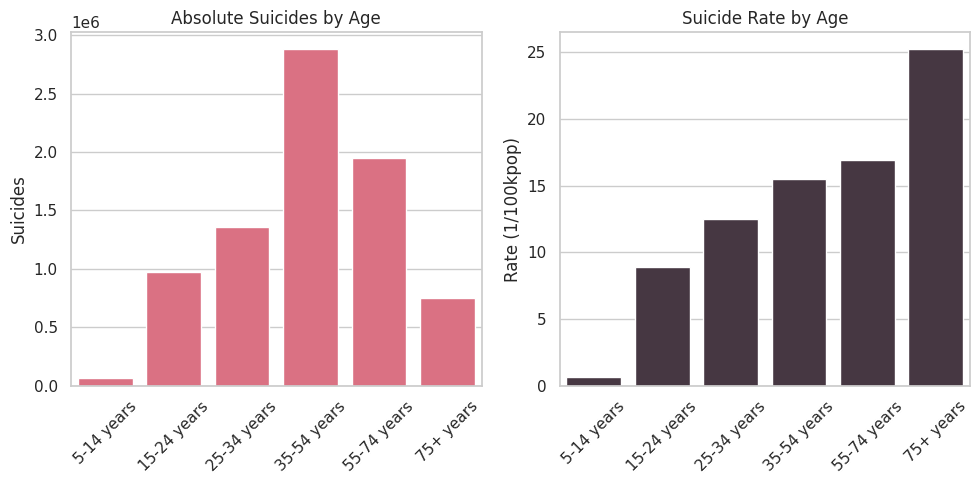

In [578]:
# Suicides by age (bar chart)
plot_suicide_charts(
    df,
    groupby_cols='age',
    chart_type='bar',
    title_suffix="by Age",
    color_abs=COLOR1,
    color_rate=COLOR2,
)

Plot Analysis:   
The majority of global suicides are by adults (35-54 years).  
The global suicide risk increases with age.  

## Highest Suicides Countries

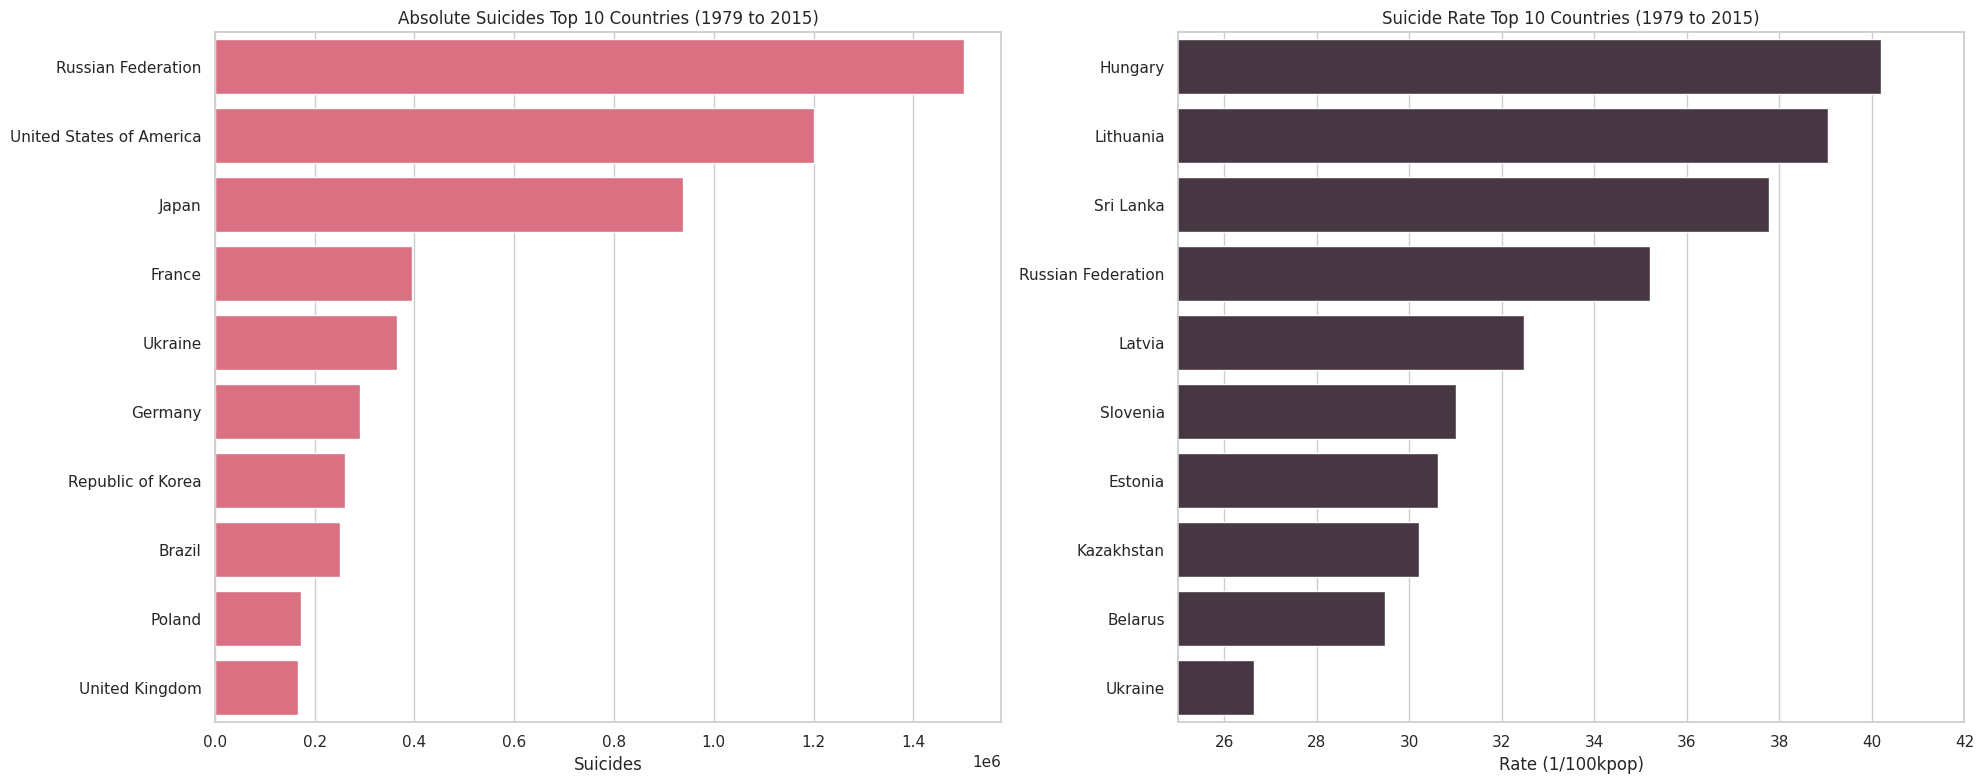

In [580]:
# Top 10 countries with the highest suicide numbers and rates
plot_suicide_charts(
    df,
    groupby_cols='country',
    chart_type='bar',
    top_n=10,
    title_suffix=f"Top 10 Countries ({YEAR_RANGE})",
    color_abs=COLOR1,
    color_rate=COLOR2,
    fig_size=(20, 8),
    y_ticks_rotation=0,
    rate_x_lim=(25, 42),
    horizontal=True,
)

Plot analysis:      
Russia, the USA, and Japan stand out with outlier numbers of suicides.  
Despite having a smaller population than the USA, Russia shows higher absolute suicide numbers, indicating a higher suicide rate. This behavior is also reflected in the suicide rate chart, where Russia appears prominently.  
Japan seems to exhibit a behavior similar to Russia’s, but less pronounced. It does not appear in the suicide rate chart, but if we included more countries, it would probably show up.
Countries with the highest suicide rates are mostly located in Europe and Asia.


In [581]:
highest_rate_countries = df.groupby('country')[['suicides_no', 'population', 'suicides_no/100kpop']].mean().nlargest(10, columns='suicides_no/100kpop').reset_index()
for index, country in highest_rate_countries.iterrows():
  total_population = country['population']
  total_suicides = country['suicides_no']

  ratio = total_population / total_suicides
  print(f"1 suicide per {int(ratio):,} people in {country['country']}")

1 suicide per 2,802 people in Hungary
1 suicide per 2,556 people in Lithuania
1 suicide per 3,081 people in Sri Lanka
1 suicide per 3,069 people in Russian Federation
1 suicide per 3,255 people in Latvia
1 suicide per 3,509 people in Slovenia
1 suicide per 3,476 people in Estonia
1 suicide per 3,863 people in Kazakhstan
1 suicide per 3,488 people in Belarus
1 suicide per 4,036 people in Ukraine


## Lowest Suicides Countries

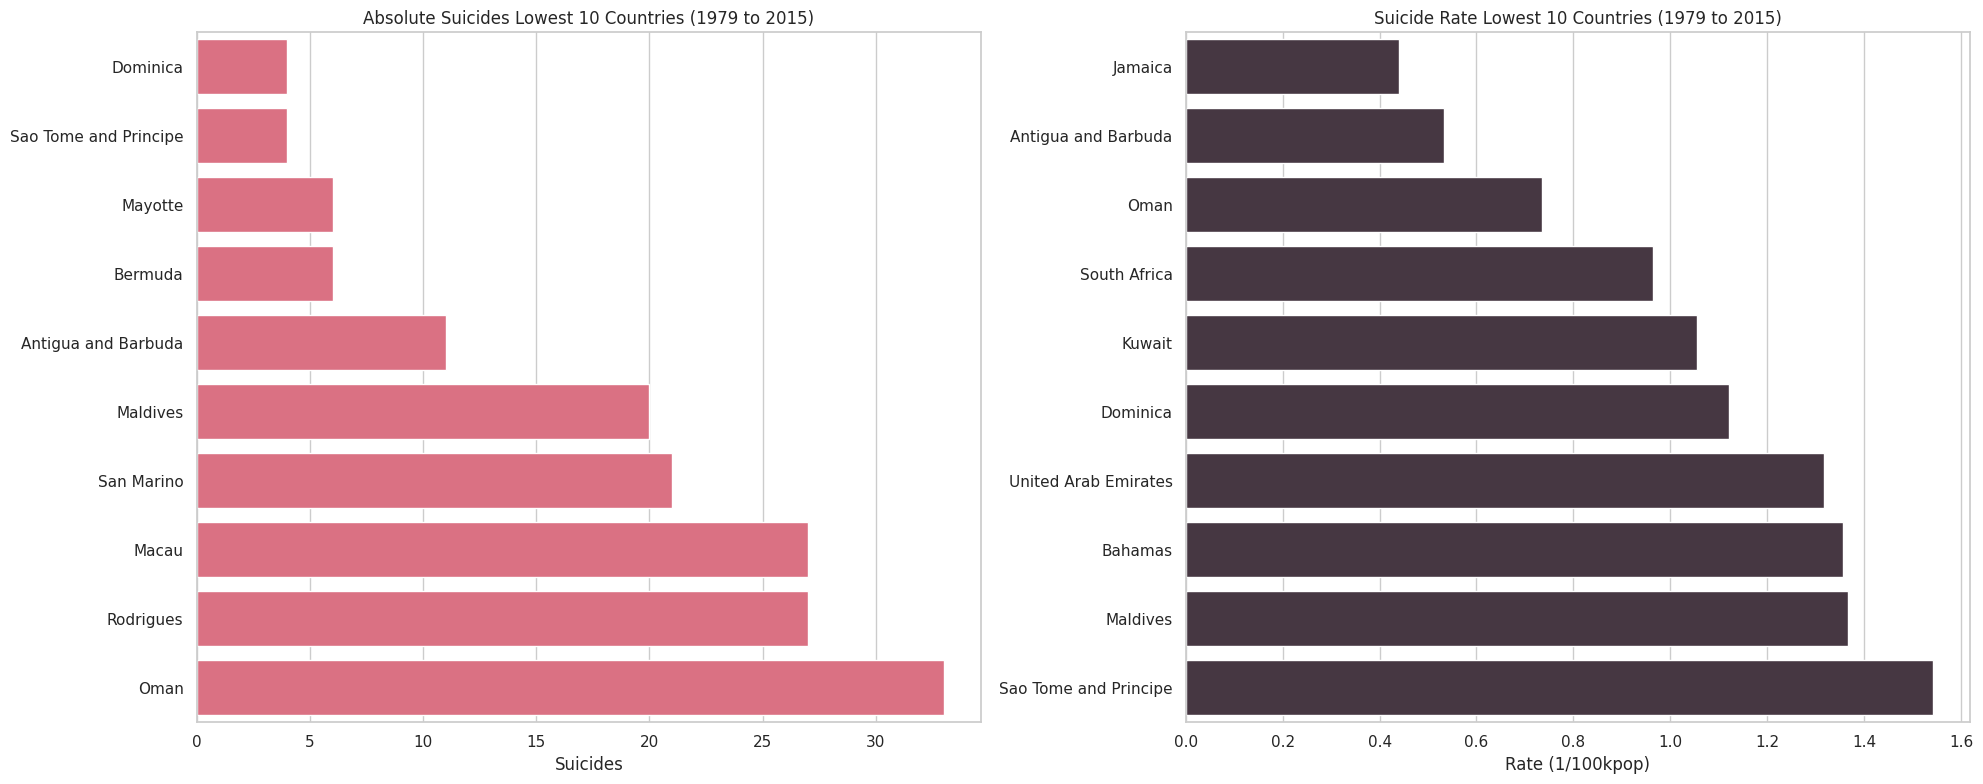

In [582]:
# Top 10 countries with the lowest suicide numbers and rates
plot_suicide_charts(
    df,
    groupby_cols='country',
    chart_type='bar',
    top_n=10,
    lowest=True,
    title_suffix=f"Lowest 10 Countries ({YEAR_RANGE})",
    color_abs=COLOR1,
    color_rate=COLOR2,
    fig_size=(20, 8),
    y_ticks_rotation=0,
    horizontal=True,
)

Plot analysis:  
Countries with the lowest Suicide Rate are mostly in Africa, Caribe and Middle East.

In [583]:
lowest_rate_countries = df.groupby('country')[['suicides_no', 'population', 'suicides_no/100kpop']].mean().nsmallest(10, columns='suicides_no/100kpop').reset_index()
for index, country in lowest_rate_countries.iterrows():
  total_population = country['population']
  total_suicides = country['suicides_no']
  ratio = total_population / total_suicides

  print(f"1 suicide per {int(ratio):,} people in {country['country']}")

1 suicide per 248,397 people in Jamaica
1 suicide per 186,810 people in Antigua and Barbuda
1 suicide per 272,335 people in Oman
1 suicide per 119,263 people in South Africa
1 suicide per 63,890 people in Kuwait
1 suicide per 95,425 people in Dominica
1 suicide per 58,685 people in United Arab Emirates
1 suicide per 68,302 people in Bahamas
1 suicide per 145,012 people in Maldives
1 suicide per 66,375 people in Sao Tome and Principe


## Age - Sex

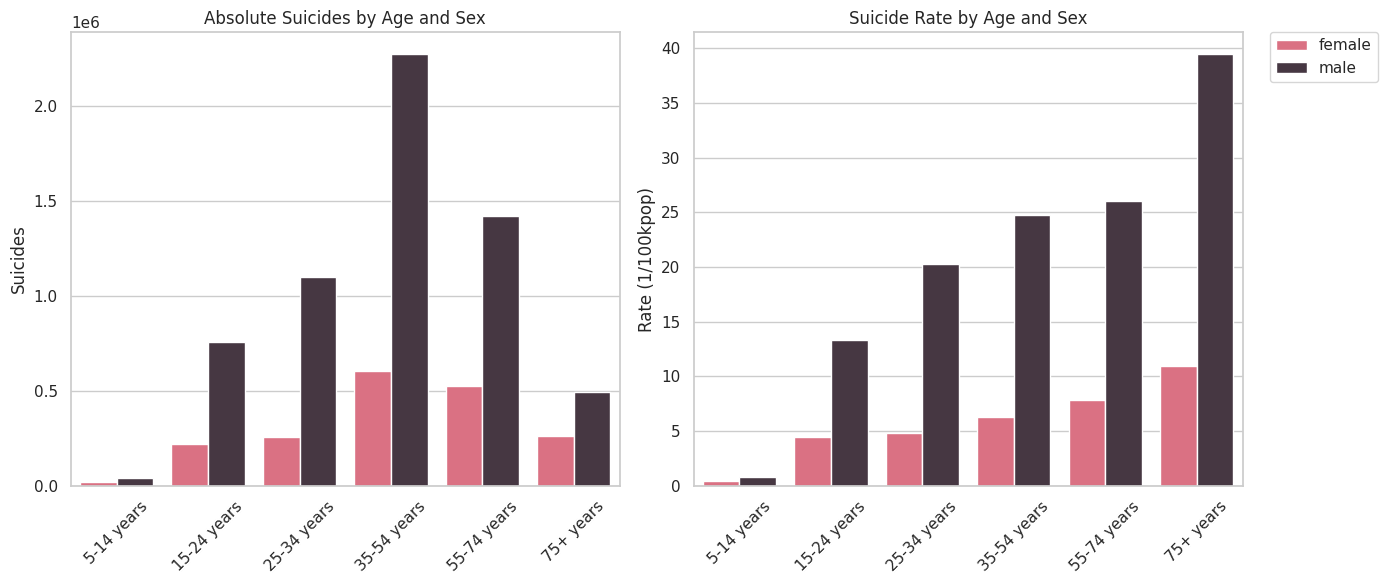

In [679]:
# Suicides by age and sex (bar chart)
plot_suicide_charts(
    df,
    groupby_cols=['age', 'sex'],
    chart_type='bar',
    title_suffix="by Age and Sex",
    fig_size=(14, 6),
    color_abs=[COLOR1, COLOR2],
    color_rate=[COLOR1, COLOR2]
)

Plot Analysis: There aren't a age group that the difference between male and females changes significantly.

## Sex - Year

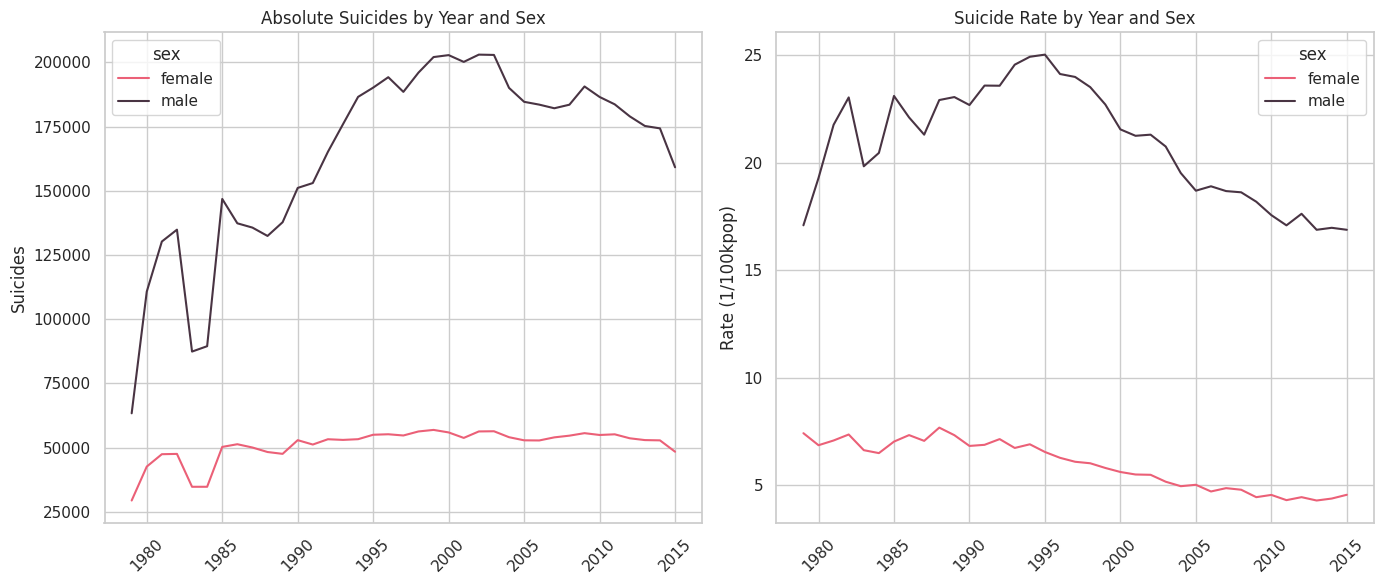

In [585]:
# Suicides by year and sex (line chart)
plot_suicide_charts(
    df,
    groupby_cols=['year', 'sex'],
    chart_type='line',
    title_suffix="by Year and Sex",
    fig_size=(14, 6),
    color_abs=[COLOR1, COLOR2],
    color_rate=[COLOR1, COLOR2]
)

Plot analysis: There isn't a year that females tend to suicide more than males world-wide.

## Year - Country

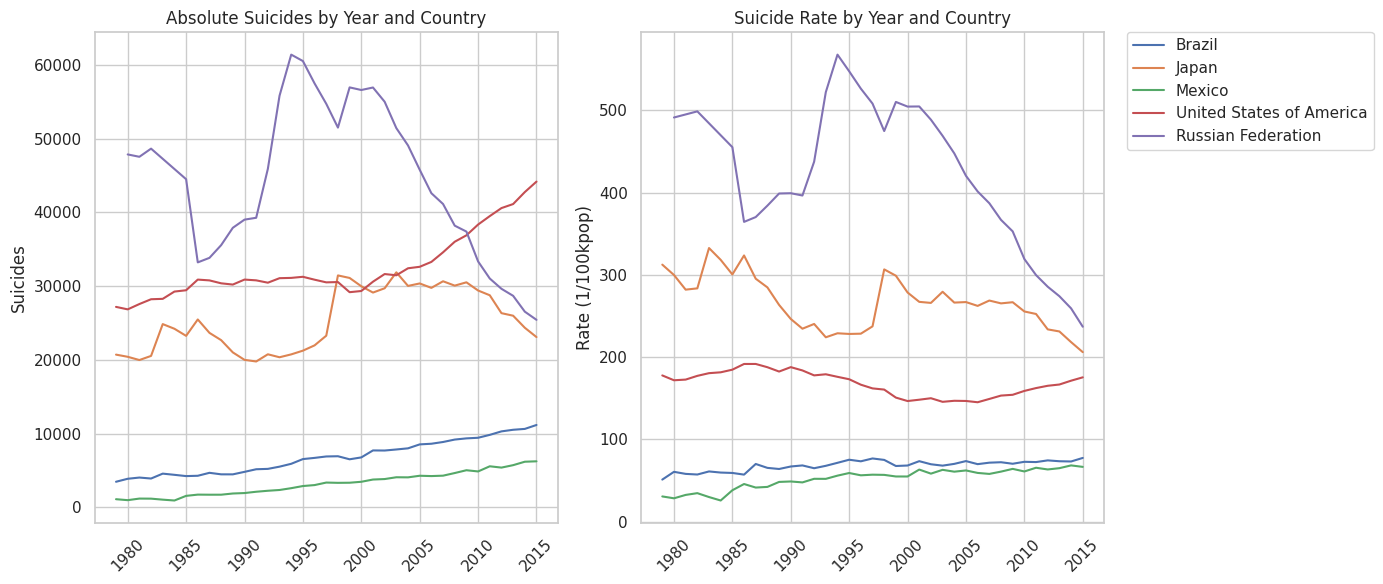

In [697]:
# Suicides by year and country (line chart)

top_5_pop = df.groupby('country', observed=True)['population'].sum().nlargest(5).reset_index()
most_populous_countries = np.array(top_5_pop['country'])

df_full = df.groupby(['country', 'year'], observed=True)[['population', 'suicides_no', 'suicides_no/100kpop']].sum().reset_index()
df_full = df_full[df_full['country'].isin(most_populous_countries)]

plot_suicide_charts(
    df_full,
    groupby_cols=['year', 'country'],
    chart_type='line',
    title_suffix="by Year and Country",
    fig_size=(14, 6),
)

Plot Analysis:  

## Sex

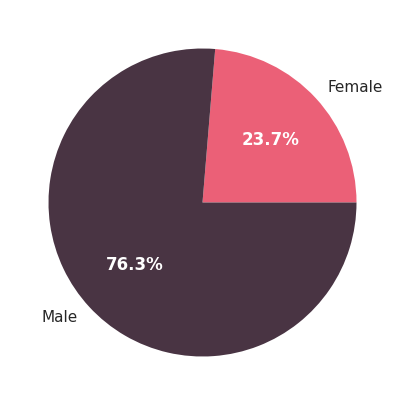

In [586]:
no_female_suicides = df[df['sex'] == 'female']['suicides_no'].sum()
no_male_suicides = df[df['sex'] == 'male']['suicides_no'].sum()

wedges, texts, autotexts = plt.pie([no_female_suicides, no_male_suicides], labels=['Female', 'Male'], autopct='%1.1f%%', wedgeprops={'linewidth': 0}, colors=[COLOR1, COLOR2])

# Style percentages
for t in autotexts:
    t.set_color('white')
    t.set_fontsize(12)
    t.set_fontweight('bold')

plt.show()

In [587]:
ratio = no_male_suicides / no_female_suicides
print(f"Men suicides occurs about {ratio:.2f}x more than women world-wide")

Men suicides occurs about 3.22x more than women


## Year - Age

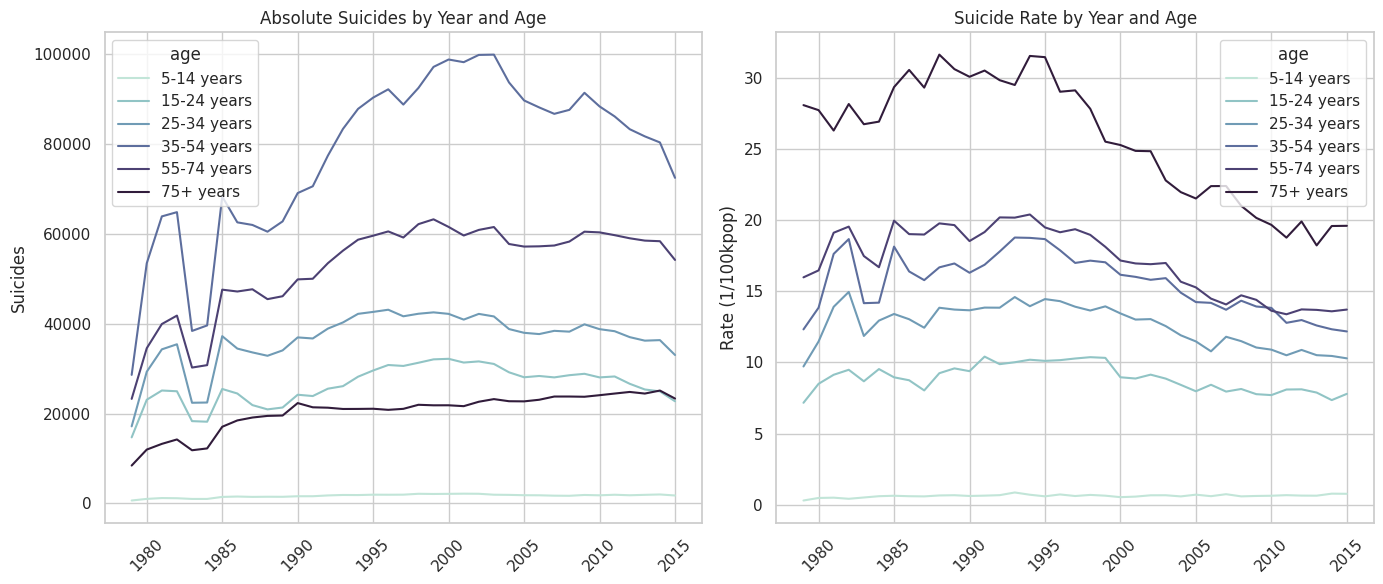

In [588]:
# Suicides by age and year (line chart)
plot_suicide_charts(
    df,
    groupby_cols=['year', 'age'],
    chart_type='line',
    title_suffix="by Year and Age",
    fig_size=(14, 6),
    color_abs=sns.cubehelix_palette(start=.5, rot=-.5),
    color_rate=sns.cubehelix_palette(start=.5, rot=-.5),
)

Plot Analysis: There isn't a year that the one age group act significantly different than the others age-groups.

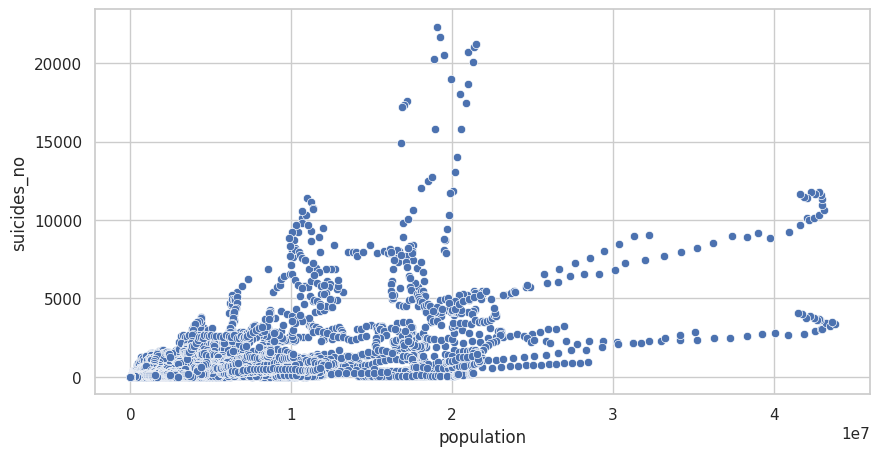

In [589]:
sns.scatterplot(x='population', y='suicides_no', data=df)
plt.show()

Plot Analysis: Oh, this chart is quite surprising — it seems that we have three distinct clusters when comparing the suicide rate with the population and the absolute number of suicides. I wonder why this separation is so well-defined...

Every point in this chart represent a country, year, sex and age combination.

This bevaviour is not exactly perfect, ideally a point would represent only a country and a year, we can groupby to achieve this.

In [590]:
df_abs = df.groupby(['country', 'year'], observed=True)[['population', 'suicides_no']].sum().reset_index()
df_abs = df_abs.sort_values(['population'], ascending=False).head(400)

This dataframe now contains information about each country-year combination, for the 8 countries with more suicides.

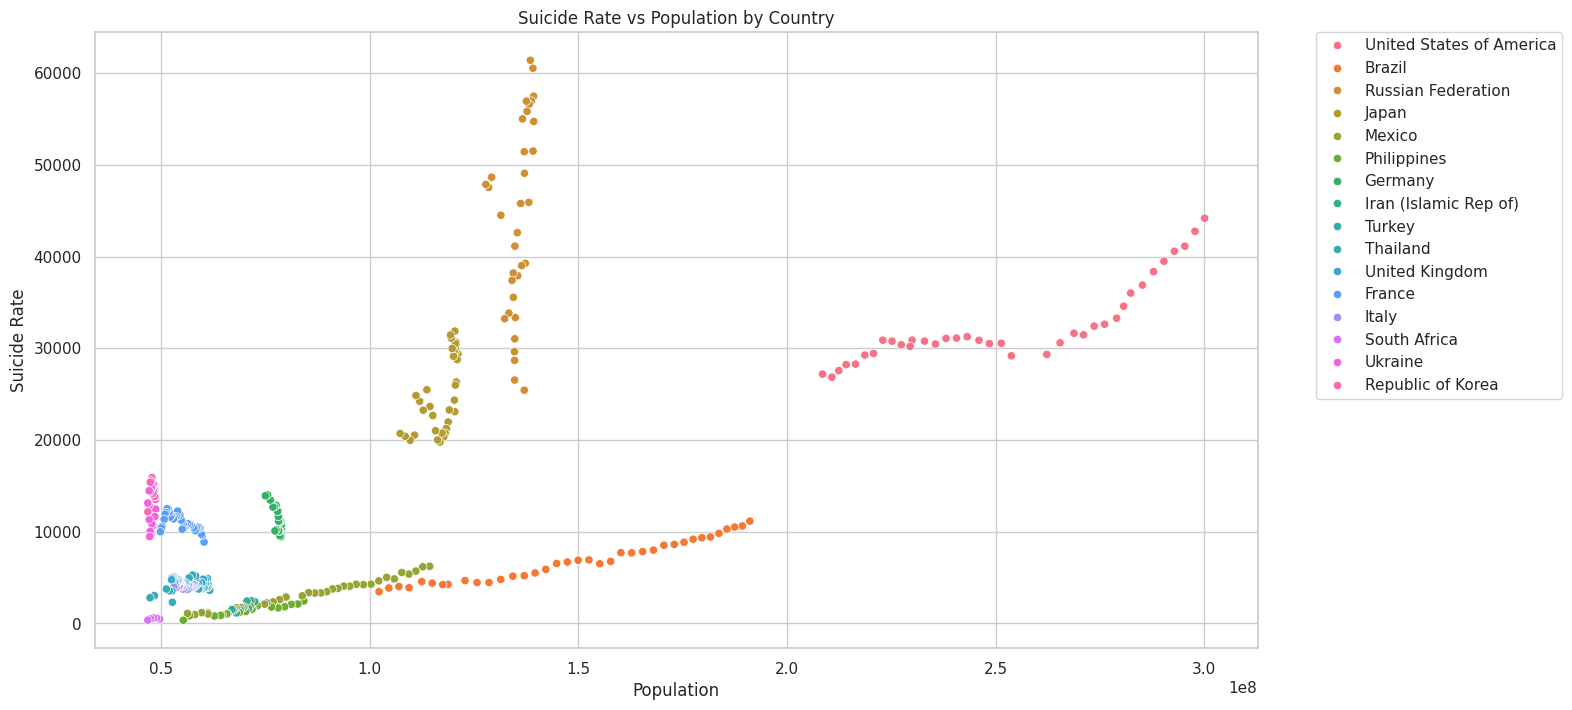

In [606]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(x='population', y='suicides_no', hue='country', data=df_abs)
plt.title('Suicide Rate vs Population by Country')
plt.xlabel('Population')
plt.ylabel('Suicide Rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Ok, now we're getting somewhere. Most countries don't show widely diverging point clusters, because their data over the year are quite uniform, but some countries show points expanding a wide range, that ones are more interesting.

It seems that some of those long lines belong to Russia, USA and Brazil — Russia appears to have a wide range of suicide counts, while the USA and Brazil shows a broad range in population. Let's plot them to investigate further.

In [607]:
def plot_country_population(country, color_abs, color_rate):
    df_country = df_abs[df_abs['country'] == country]
    sns.scatterplot(data=df_country, x='year', y='population', color=color_abs)
    # Suicides by year (line chart)
    print(f"{country}'s population varied {df_country['population'].max() / df_country['population'].min():.3}-fold from {YEAR_RANGE}.")
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.title(f"{country}'s Population by Year")
    plt.tight_layout()
    plt.show()

In [609]:
def plot_country_suicide(country, color_abs, color_rate):
    plot_suicide_charts(
          df[df['country'] == country],
          groupby_cols='year',
          chart_type='line',
          title_suffix=f"{country} by Year",
          color_abs=color_abs,
          color_rate=color_rate,
      )

## Russia

Russian Federation's population varied 1.09-fold from 1979 to 2015.


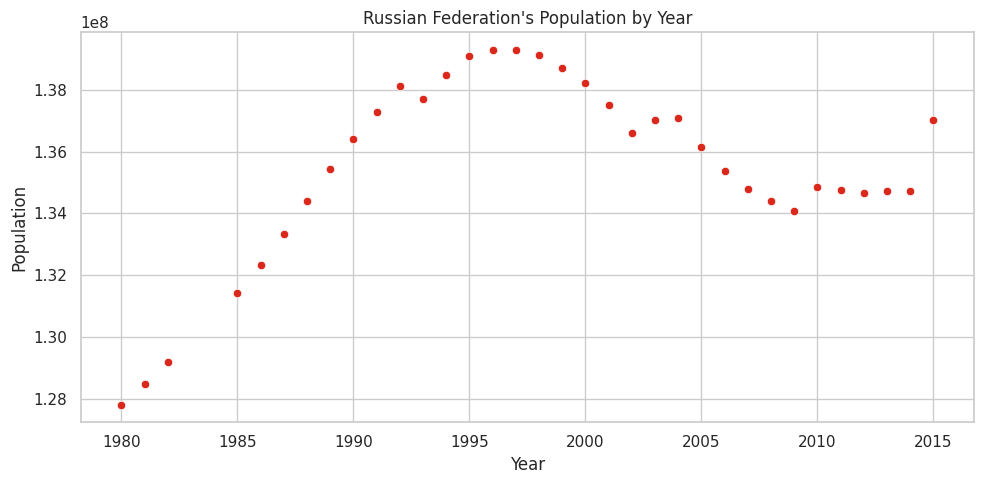

In [608]:
plot_country_population(country='Russian Federation', color_abs='#DA291C', color_rate='#0033A0')

The Russian population don't substantially changed over these years.

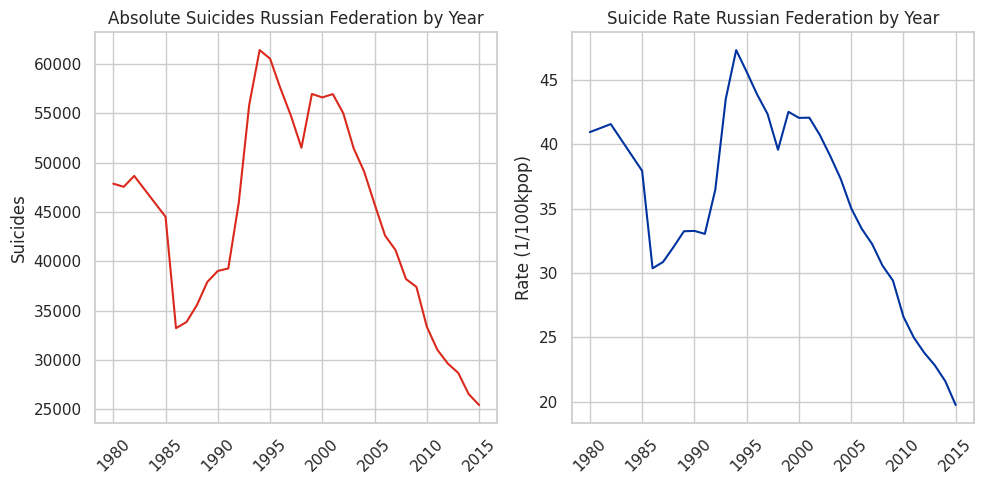

In [610]:
plot_country_suicide(country='Russian Federation', color_abs='#DA291C', color_rate='#0033A0')

But the suicide data vary a lot.

Russia Final Analysis:  
Throughout this period, the population did not show a notable difference.  
From 1980 to around 1986, the suicide rate dropped from around 40 to about 30.  
Up to around 1994, it increased, reaching its highest peak above 45.  
Since then, it has been steadily decreasing.  

## USA

United States of America's population varied 1.44-fold from 1979 to 2015.


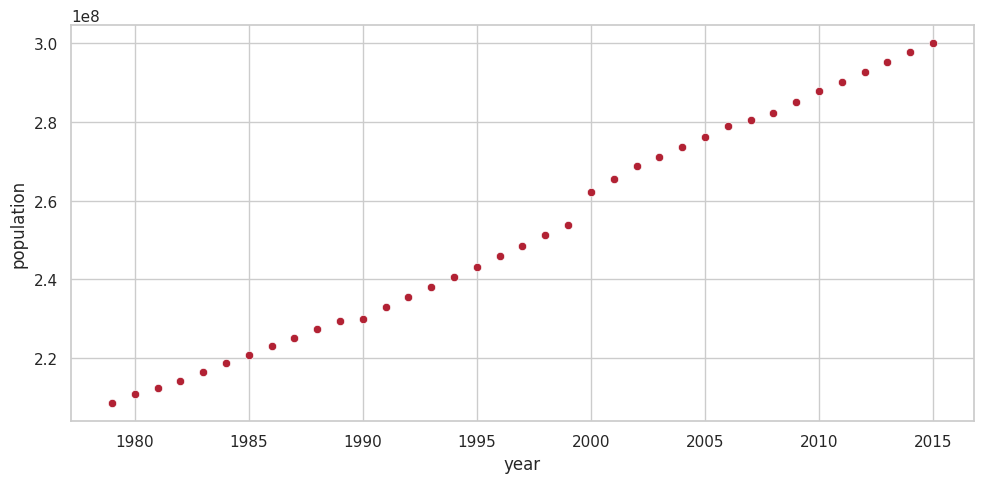

In [596]:
plot_country_population(country='United States of America', color_abs='#B22234', color_rate='#3C3B6E')

Ok, so, in fact the American population grows significantly in this period, this quite explain that wide point range.

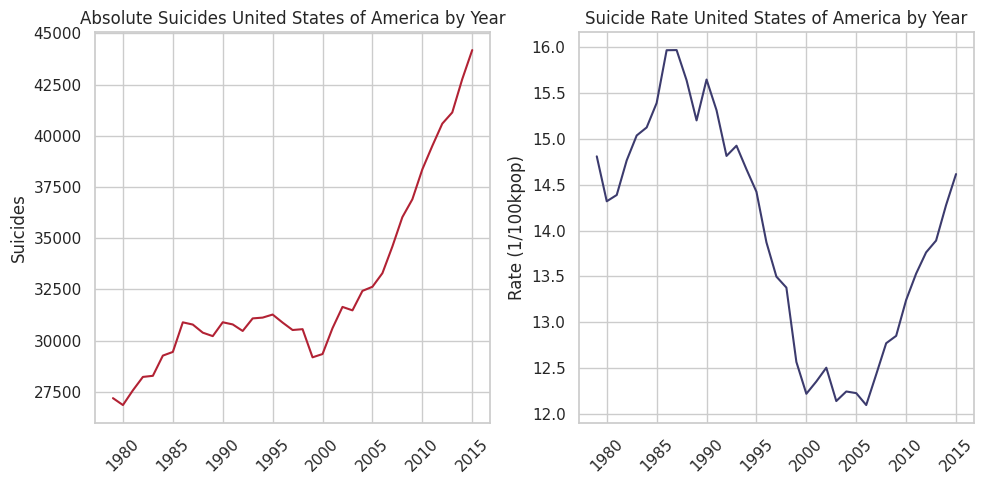

<Figure size 1000x500 with 0 Axes>

In [597]:
plot_country_suicide(country='United States of America', color_abs='#B22234', color_rate='#3C3B6E')

With population growth, the number of suicides tends to rise as well.  
Looking at this two charts we can see what's happening in the scatter plot one.

USA Final Analysis:  
Throughout this period, the population grew steadily.  
From around 1985 to 2000, the suicide rate dropped significantly.  
Between 2000 and 2005, the rate began to stabilize.  
After that, it surged dramatically until 2015.

## Brazil

Brazil's population varied 1.87-fold from 1979 to 2015.


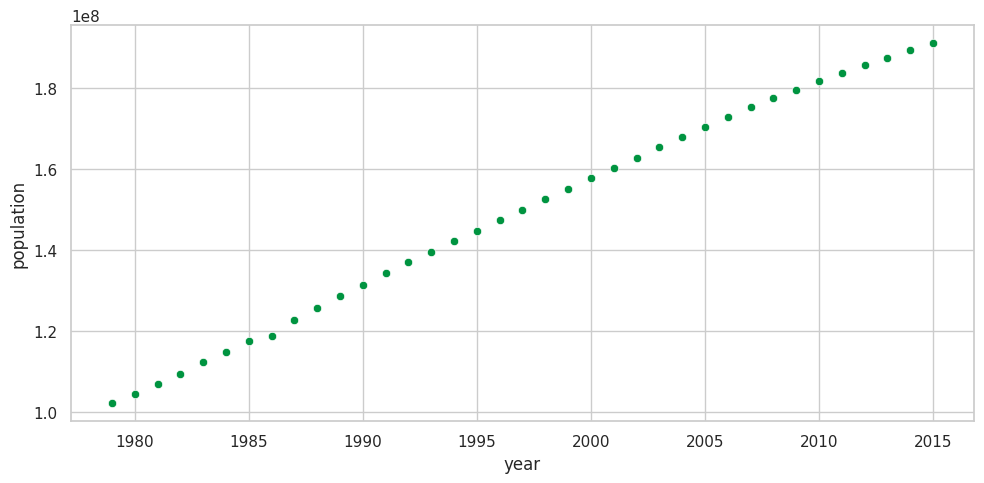

In [598]:
plot_country_population(country='Brazil', color_abs='#009440', color_rate='#0033A0')

Brazil's population almost doubled in this period.

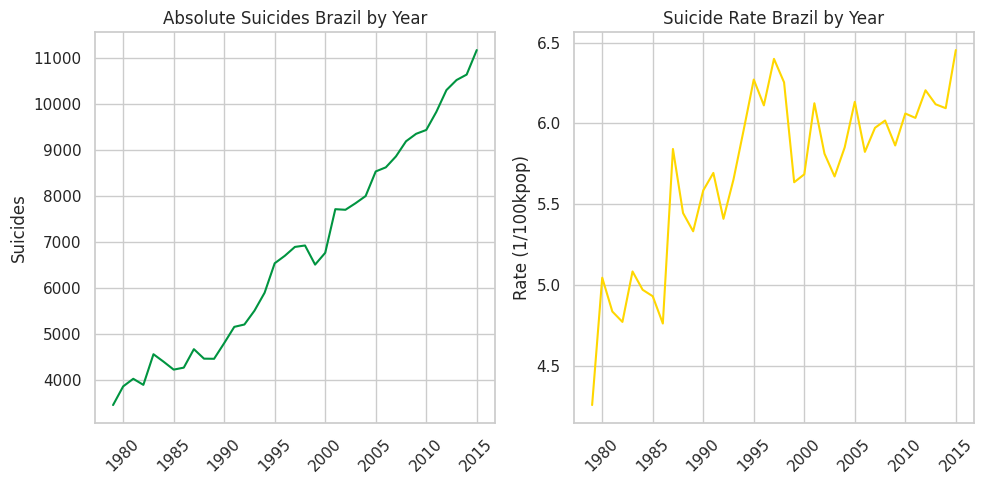

<Figure size 1000x500 with 0 Axes>

In [599]:
plot_country_suicide(country='Brazil', color_abs='#009440', color_rate='gold')

Brazil Final Analysis:  
Throughout this period, both the population and the number of suicide cases grew steadily.  
The suicide rate was somewhat more erratic, but still followed a similar upward trend.